In [465]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, Activation
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from datetime import datetime,date
from sklearn.model_selection import train_test_split

In [466]:
df=pd.read_csv('LendingClub.csv')
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,loan_status,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,RENT,117000.0,Not Verified,Fully Paid,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,MORTGAGE,65000.0,Not Verified,Fully Paid,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,RENT,43057.0,Source Verified,Fully Paid,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,RENT,54000.0,Not Verified,Fully Paid,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,MORTGAGE,55000.0,Verified,Charged Off,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [467]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395219 entries, 0 to 395218
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             395219 non-null  float64
 1   term                  395219 non-null  object 
 2   int_rate              395219 non-null  float64
 3   installment           395219 non-null  float64
 4   grade                 395219 non-null  object 
 5   sub_grade             395219 non-null  object 
 6   home_ownership        395219 non-null  object 
 7   annual_inc            395219 non-null  float64
 8   verification_status   395219 non-null  object 
 9   loan_status           395219 non-null  object 
 10  purpose               395219 non-null  object 
 11  dti                   395219 non-null  float64
 12  earliest_cr_line      395219 non-null  object 
 13  open_acc              395219 non-null  float64
 14  pub_rec               395219 non-null  float64
 15  

In [468]:
#Calculating the % of Null values in each column
df.isnull().sum()/df.shape[0]

loan_amnt               0.0
term                    0.0
int_rate                0.0
installment             0.0
grade                   0.0
sub_grade               0.0
home_ownership          0.0
annual_inc              0.0
verification_status     0.0
loan_status             0.0
purpose                 0.0
dti                     0.0
earliest_cr_line        0.0
open_acc                0.0
pub_rec                 0.0
revol_bal               0.0
revol_util              0.0
total_acc               0.0
initial_list_status     0.0
application_type        0.0
mort_acc                0.0
pub_rec_bankruptcies    0.0
address                 0.0
dtype: float64

**Good, there are no NULL values**

In [469]:
#Lets check which columns are numeric and non-numeric
print("Distinct DataTypes:",list(df.dtypes.unique()))

Distinct DataTypes: [dtype('float64'), dtype('O')]


In [470]:
#Create a temp dataset with the datatype of columns
temp = pd.DataFrame(df.dtypes)
temp.columns = ["DataType"]
#Extracting the object columns from the above dataframe
categorical_columns = temp.index[temp["DataType"] == 'O'].values
#Check the number of distinct values in each categorical column
for column in categorical_columns:
  print(column+" column has :",str(len(df[column].unique()))+" distinct values")

term column has : 2 distinct values
grade column has : 7 distinct values
sub_grade column has : 35 distinct values
home_ownership column has : 6 distinct values
verification_status column has : 3 distinct values
loan_status column has : 2 distinct values
purpose column has : 14 distinct values
earliest_cr_line column has : 684 distinct values
initial_list_status column has : 2 distinct values
application_type column has : 3 distinct values
address column has : 392898 distinct values


In [471]:
df['home_ownership'].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: home_ownership, dtype: int64

There are very few OTHER,NONE and ANY rows. We should filter these outliers

In [491]:
df = df[(df['home_ownership'] != 'OTHER') & (df['home_ownership'] != 'NONE') & (df['home_ownership'] != 'ANY')]
df.shape

(395077, 23)

In [492]:
df['pub_rec'].value_counts()

0.0     337348
1.0      49712
2.0       5474
3.0       1521
4.0        527
5.0        237
6.0        122
7.0         56
8.0         34
9.0         12
10.0        11
11.0         8
13.0         4
12.0         4
19.0         2
86.0         1
40.0         1
17.0         1
15.0         1
24.0         1
Name: pub_rec, dtype: int64

Public Records have negligible # of values after 3. Lets drop these values.

In [494]:
df = df[(df['pub_rec'] <= 3)]
df.shape

(394055, 23)

In [495]:
df['pub_rec_bankruptcies'].value_counts()

0.0    349449
1.0     42512
2.0      1789
3.0       305
Name: pub_rec_bankruptcies, dtype: int64

Public Record Bankruptcies have negligible # of values after 1. Lets drop these values.

In [497]:
df = df[(df['pub_rec_bankruptcies'] <= 1)]
df.shape

(391961, 23)

In [498]:
#Lets change the term column to numerical. Remove the last 6 characters representing months string. 
#That way if there a term of 108 terms, that will also be converted correctly 
df['term'] = df['term'].apply(lambda term: pd.to_numeric(str(term)[:-6]))

In [499]:
df['grade'].unique()

array(['B', 'A', 'C', 'E', 'D', 'F', 'G'], dtype=object)

In [500]:
#Now lets take a look at grade column which has 7 distinct values.
#NOTE: I was going to use from sklearn import preprocessing, but was not sure whether it was allowed in the assignment
def get_grade(df):
    grade = np.where(df["grade"] == "A",1,np.where(df["grade"] == "B",2,np.where(df["grade"] == "C",3,np.where(df["grade"] == "D",4,np.where(df["grade"] == "E",5,np.where(df["grade"] == "F",6,np.where(df["grade"] == "G",7,100)))))))
    return grade

df['grade'] = get_grade(df)

In [501]:
df['grade'][:10]

0    2
1    2
2    2
3    1
4    3
5    3
6    1
7    2
8    2
9    3
Name: grade, dtype: int32

In [502]:
df['sub_grade'].unique()

array(['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4',
       'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5',
       'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4',
       'F2', 'G3'], dtype=object)

In [506]:
#For the sub_grade column A1 will translate to 1, B4 will translate to 4 etc. As the grade is already taken care of in grade column
#Lets worry only about the numeric value of sub_grade
def get_subgrade(arr):
    sub_grade_num = df['sub_grade'].apply(lambda sub_grade: pd.to_numeric(str(sub_grade)[-1]))
    return sub_grade_num

In [507]:
df['sub_grade'] = get_subgrade(df['sub_grade'])
df['sub_grade'][:10]

0    4
1    5
2    3
3    2
4    5
5    3
6    1
7    2
8    3
9    5
Name: sub_grade, dtype: int64

In [508]:
df['home_ownership'].unique()

array(['RENT', 'MORTGAGE', 'OWN'], dtype=object)

In [509]:
#Now lets take a look at home_ownership column which has 6 distinct values. Lets convert them to numerical
def get_home_ownership(df):
    home_ownership = np.where(df["home_ownership"] == "RENT",1,np.where(df["home_ownership"] == "MORTGAGE",2,np.where(df["home_ownership"] == "OWN",3,np.where(df["home_ownership"] == "OTHER",4,np.where(df["home_ownership"] == "ANY",5,np.where(df["home_ownership"] == "NONE",6,100))))))
    return home_ownership

df['home_ownership'] = get_home_ownership(df)

In [510]:
df['verification_status'].unique()

array(['Not Verified', 'Source Verified', 'Verified'], dtype=object)

In [511]:
#Now lets take a look at verification status column which has 3 distinct values. Lets convert them to numerical
def get_verification_status(df):
    verification_status = np.where(df["verification_status"] == "Not Verified",1,np.where(df["verification_status"] == "Source Verified",2,np.where(df["verification_status"] == "Verified",3,100)))
    return verification_status

df['verification_status'] = get_verification_status(df)

In [512]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [513]:
#Now lets take a look at loan status column which has 2 distinct values.This is the target column. We should convert it to binary 0 & 1
def get_loan_status(df):
    loan_status = np.where(df["loan_status"] == "Fully Paid",0,np.where(df["loan_status"] == "Charged Off",1,100))
    #loan_status = loan_status.apply(lambda status: int(status))
    return loan_status.astype(int)

df['loan_status'] = get_loan_status(df)

In [514]:
#Earliest credit line is in MON-YYYY format. We are interested in the duration of time for which it is open. We will convert 
#the value to the number of months for which earliest credit line is open

df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda openDate: (date.today().year - datetime.strptime(openDate, '%b-%Y').date().year) * 12 + (date.today().month - datetime.strptime(openDate, '%b-%Y').date().month))
df['earliest_cr_line'][:10]

0    359
1    190
2    153
3    164
4    254
5    184
6    177
7    308
8    311
9    269
Name: earliest_cr_line, dtype: int64

In [515]:
df['initial_list_status'].unique()

array(['w', 'f'], dtype=object)

In [516]:
#Now lets take a look at initial status column which has 2 distinct values.
df['initial_list_status'] = np.where(df['initial_list_status'] == "w",0,np.where(df['initial_list_status'] == "f",1,100))

In [517]:
df['application_type'].unique()

array(['INDIVIDUAL', 'JOINT', 'DIRECT_PAY'], dtype=object)

In [518]:
#Now lets take a look at application type column which has 3 distinct values. Lets convert them to numerical
def get_application_type(df):
    application_type = np.where(df["application_type"] == "INDIVIDUAL",1,np.where(df["application_type"] == "JOINT",2,np.where(df["application_type"] == "DIRECT_PAY",3,100)))
    return application_type

df['application_type'] = get_application_type(df)

In [519]:
df['purpose'].unique()

array(['vacation', 'debt_consolidation', 'credit_card',
       'home_improvement', 'small_business', 'major_purchase', 'other',
       'medical', 'wedding', 'car', 'moving', 'house', 'educational',
       'renewable_energy'], dtype=object)

In [520]:
#Now lets take a look at purpose column which has 14 distinct values.
def get_purpose(df):
    purpose = np.where(df["purpose"] == "vacation",1,np.where(df["purpose"] == "debt_consolidation",2,np.where(df["purpose"] == "credit_card",3,np.where(df["purpose"] == "home_improvement",4,np.where(df["purpose"] == "small_business",5,np.where(df["purpose"] == "major_purchase",6,np.where(df["purpose"] == "other",7,np.where(df["purpose"] == "medical",8,np.where(df["purpose"] == "wedding",8,np.where(df["purpose"] == "car",10,np.where(df["purpose"] == "moving",11,np.where(df["purpose"] == "house",12,np.where(df["purpose"] == "educational",13,np.where(df["purpose"] == "renewable_energy",14,100))))))))))))))
    return purpose

df['purpose'] = get_purpose(df)

In [521]:
df['purpose'][:10]

0    1
1    2
2    3
3    3
4    3
5    2
6    4
7    3
8    2
9    2
Name: purpose, dtype: int32

In [522]:
#extract zip code from address
df['address'] =  df['address'].apply(lambda address:pd.to_numeric(str(address)[-5:]))

In [523]:
#Lets check whether all columns are numeric
print("Distinct DataTypes:",list(df.dtypes.unique()))

Distinct DataTypes: [dtype('float64'), dtype('int64'), dtype('int32')]


**All our values are now numeric**

In [524]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,loan_status,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36,11.44,329.48,2,4,1,117000.0,1,0,...,16.0,0.0,36369.0,41.8,25.0,0,1,0.0,0.0,22690
1,8000.0,36,11.99,265.68,2,5,2,65000.0,1,0,...,17.0,0.0,20131.0,53.3,27.0,1,1,3.0,0.0,5113
2,15600.0,36,10.49,506.97,2,3,1,43057.0,2,0,...,13.0,0.0,11987.0,92.2,26.0,1,1,0.0,0.0,5113
3,7200.0,36,6.49,220.65,1,2,1,54000.0,1,0,...,6.0,0.0,5472.0,21.5,13.0,1,1,0.0,0.0,813
4,24375.0,60,17.27,609.33,3,5,2,55000.0,3,1,...,13.0,0.0,24584.0,69.8,43.0,1,1,1.0,0.0,11650


In [525]:
X=df.loc[:, df.columns != 'loan_status']
y=df[['loan_status']]

In [526]:
X_train,X_test,y_train,y_test=train_test_split(X.values,y.values,test_size=0.3,random_state=100)

In [527]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((274372, 22), (117589, 22), (274372, 1), (117589, 1))

In [528]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [529]:
#Checking the distribution of values in the target
df["loan_status"].value_counts()/df.shape[0]

0    0.804172
1    0.195828
Name: loan_status, dtype: float64

**So our baseline accuracy should be 80%**

In [ ]:
model=Sequential()

#For the first layer number of neurons is equal to number of input dimensions
model.add(Dropout(0.2))
model.add(Dense(X_train.shape[1],input_dim=X_train.shape[1],activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),batch_size=32,epochs=10)

Train on 274372 samples, validate on 117589 samples
Epoch 1/10
274372/274372 [==============================] - 38s 140us/sample - loss: 0.4026 - accuracy: 0.8442 - val_loss: 0.4479 - val_accuracy: 0.8035
Epoch 2/10
274372/274372 [==============================] - 41s 150us/sample - loss: 0.3915 - accuracy: 0.8484 - val_loss: 0.5243 - val_accuracy: 0.8035
Epoch 3/10
274372/274372 [==============================] - 41s 149us/sample - loss: 0.3887 - accuracy: 0.8489 - val_loss: 0.4446 - val_accuracy: 0.8035
Epoch 4/10
274372/274372 [==============================] - 40s 147us/sample - loss: 0.3591 - accuracy: 0.8636 - val_loss: 0.3446 - val_accuracy: 0.8538
Epoch 5/10
274372/274372 [==============================] - 40s 144us/sample - loss: 0.3359 - accuracy: 0.8711 - val_loss: 0.4099 - val_accuracy: 0.7997
Epoch 6/10
274372/274372 [==============================] - 40s 144us/sample - loss: 0.3332 - accuracy: 0.8716 - val_loss: 0.3783 - val_accuracy: 0.8401
Epoch 7/10
274372/274372 [====

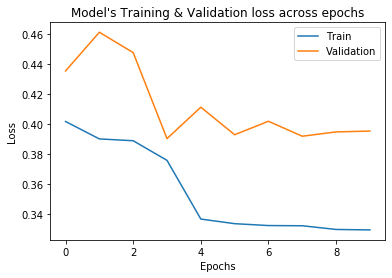

In [533]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

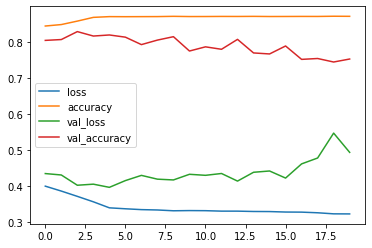

In [463]:
loss=pd.DataFrame(model.history.history)
loss.plot()